In [1]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [4]:
llm.invoke("hi").content

'Hi there! 👋\n\nWhat can I do for you today? 😊\n'

In [5]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [6]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [7]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

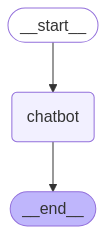

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
input={"messages":["hi, my name is sunny"]}

In [12]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is sunny', additional_kwargs={}, response_metadata={}, id='8cbb19d9-8c76-45f3-9143-ece42e4c5ea5'),
  AIMessage(content="Hi Sunny, it's nice to meet you! 👋\n\nWhat can I do for you today? 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 15, 'total_tokens': 40, 'completion_time': 0.045454545, 'prompt_time': 0.001913596, 'queue_time': 0.229837158, 'total_time': 0.047368141}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-effb19f6-e01d-4e7f-b69c-924b6ffc1f9e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 25, 'total_tokens': 40})]}

In [13]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hi Sunny, it's nice to meet you! 😊\n\nWhat can I do for you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 15, 'total_tokens': 39, 'completion_time': 0.043636364, 'prompt_time': 0.001911665, 'queue_time': 0.22988704599999998, 'total_time': 0.045548029}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-539fa259-185d-46cb-b449-49a66a4333d2-0', usage_metadata={'input_tokens': 15, 'output_tokens': 24, 'total_tokens': 39})]}




In [14]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [15]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [19]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [20]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000159A88EE0C0>)

In [21]:
tools=[search]

In [22]:
tool_node=ToolNode(tools)

In [23]:
llm_with_tool=llm.bind_tools(tools)

In [24]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [25]:
response=call_model({"messages": ["hi how are you?"]})

In [26]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_en5m', 'function': {'arguments': '{"query":"how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 941, 'total_tokens': 1021, 'completion_time': 0.145454545, 'prompt_time': 0.041241184, 'queue_time': 0.228956746, 'total_time': 0.186695729}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4496eb73-9d93-4aa6-99e1-9cb8dfe4f5c6-0', tool_calls=[{'name': 'search', 'args': {'query': 'how are you'}, 'id': 'call_en5m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 80, 'total_tokens': 1021})]}

[AIMessage(content='I am doing well, thank you. How are you?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 941, 'total_tokens': 955, 'completion_time': 0.025454545, 'prompt_time': 0.030139486, 'queue_time': 0.0028640919999999986, 'total_time': 0.055594031}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-7176e5d9-307e-4644-93e2-99d358198179-0', usage_metadata={'input_tokens': 941, 'output_tokens': 14, 'total_tokens': 955})]

In [27]:
messages = response['messages']

In [28]:
last_message=messages[-1]

In [29]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'how are you'},
  'id': 'call_en5m',
  'type': 'tool_call'}]

In [30]:
response=call_model({"messages": ["what is a weather in India?"]})

In [31]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eth4', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 943, 'total_tokens': 1023, 'completion_time': 0.145454545, 'prompt_time': 0.033218182, 'queue_time': 0.238613381, 'total_time': 0.178672727}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c4961fe9-5611-43c9-81b3-fba197b7339c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_eth4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 80, 'total_tokens': 1023})]}

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5q56', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 943, 'total_tokens': 1025, 'completion_time': 0.149090909, 'prompt_time': 0.031104902, 'queue_time': 0.003129146000000003, 'total_time': 0.180195811}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35d08bfe-0844-4902-8d36-71630335dd9e-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_5q56', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 82, 'total_tokens': 1025})]

In [32]:
messages = response['messages']

In [33]:
last_message=messages[-1]

In [34]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': 'call_eth4',
  'type': 'tool_call'}]

In [35]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [36]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

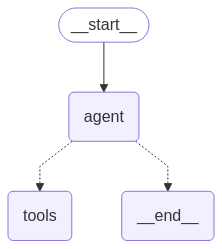

In [37]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [38]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='966c33cb-40d9-400f-9063-23171d67b208'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gx9g', 'function': {'arguments': '{"query":"hi how are you"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 941, 'total_tokens': 1024, 'completion_time': 0.150909091, 'prompt_time': 0.054744463, 'queue_time': 0.237211678, 'total_time': 0.205653554}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d2486fa-8a5a-42a9-a5f4-9a40910ee9a9-0', tool_calls=[{'name': 'search', 'args': {'query': 'hi how are you'}, 'id': 'call_gx9g', 'type': 'tool_call'}], usage_metadata={'input_tokens': 941, 'output_tokens': 83, 'total_tokens': 1024}),
  ToolMessage(content="It's 90 degrees and sunny.", name='search', id='89d064f2-5af3-4685-b74a-6fb9b13e

In [39]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='446af464-669b-4efa-a3b3-01f1eeba555a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_h6e8', 'function': {'arguments': '{"query":"weather in san francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 942, 'total_tokens': 1025, 'completion_time': 0.150909091, 'prompt_time': 0.033270583, 'queue_time': 0.231351039, 'total_time': 0.184179674}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9857903c-d167-4ff1-b82a-02ca9dfa1b43-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in san francisco'}, 'id': 'call_h6e8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 83, 'total_tokens': 1025}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='f7

In [87]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [88]:
app = workflow.compile()

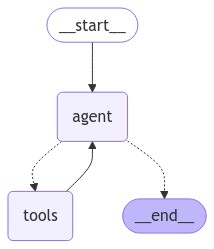

In [89]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [90]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xt3r', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 942, 'total_tokens': 1022, 'completion_time': 0.145454545, 'prompt_time': 0.030358503, 'queue_time': 0.002830924000000002, 'total_time': 0.175813048}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-166abd47-7d7a-4f4f-a282-fff9a19b2e2b-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'call_xt3r', 'type': 'tool_call'}], usage_metadata={'input_tokens': 942, 'output_tokens': 80, 'total_tokens': 1022})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='5193a4e8-8ed9-400e-b0ea-51c22d84a17a', tool_call_id='call_xt3r')]}


her

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [21]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [22]:
app3 = workflow3.compile(checkpointer = memory)

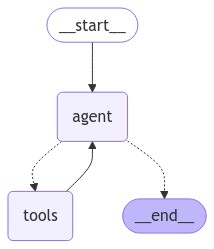

In [23]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
config = {"configurable": {"thread_id": "1"}}

In [25]:
events = app3.stream(
    {"messages": ["Hi there! My name is Sunny."]}, config, stream_mode="values"
)

In [26]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Sunny.
================================== Ai Message ==================================

Nice to meet you, Sunny!


In [27]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [28]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Your name is Sunny.


In [29]:
memory.get(config)

{'v': 1,
 'ts': '2024-10-29T12:40:56.597779+00:00',
 'id': '1ef95f30-b00f-62c6-8010-f7735af1bd97',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Sunny.', additional_kwargs={}, response_metadata={}, id='56dc95d3-7235-495e-9f50-381c11aa992b'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pcx5', 'function': {'arguments': '{"query":"My name is Sunny"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 944, 'total_tokens': 1027, 'completion_time': 0.150909091, 'prompt_time': 0.030613844, 'queue_time': 0.0028480129999999965, 'total_time': 0.181522935}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f324947-3d86-4255-8793-7b196b35df15-0', tool_calls=[{'name': 'search', 'args': {'query': 'My name is Sunny'}, 'id': 'call_pcx5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 944, 'ou